# 🧠 VAE Implementation for F1 Position Prediction
## Variational Autoencoder for Feature Learning and Dimensionality Reduction

This notebook implements a VAE to:
- Learn latent representations of F1 driver/race features
- Compress 10 continuous features into 4D latent space
- Generate encoded features for Bayesian Network integration
- Predict finish position probabilities using learned representations

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import pickle
import glob
import os
from datetime import datetime
import warnings
import json

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("🧠 VAE Implementation libraries loaded")
print(f"🔥 PyTorch version: {torch.__version__}")
print(f"🎯 Device: {'CUDA' if torch.cuda.is_available() else 'CPU'}")

🧠 VAE Implementation libraries loaded
🔥 PyTorch version: 2.8.0+cpu
🎯 Device: CPU


## 📂 Load Preprocessed Data

In [11]:
# Load VAE input data - Fixed to use correct file pattern
vae_input_files = glob.glob('data/preprocessed/*vae_input_*.csv')
if vae_input_files:
    latest_vae_file = max(vae_input_files, key=os.path.getctime)
    vae_df = pd.read_csv(latest_vae_file)
    print(f"📂 Loaded VAE input data: {latest_vae_file}")
    print(f"📊 Shape: {vae_df.shape}")
    print(f"🏎️ Features: {list(vae_df.columns)}")
    
    # Verify this is Singapore GP data
    if 'singapore' in latest_vae_file.lower():
        print(f"✅ Confirmed: Using Singapore GP VAE input data")
    else:
        print(f"⚠️ Warning: File doesn't appear to be Singapore GP specific")
else:
    print("❌ No VAE input files found. Please run preprocessing first.")
    vae_df = pd.DataFrame()

# Load preprocessing artifacts for scalers and splits - Fixed pattern
artifact_files = glob.glob('data/preprocessed/preprocessing_artifacts_*.pkl')
if artifact_files:
    latest_artifacts = max(artifact_files, key=os.path.getctime)
    with open(latest_artifacts, 'rb') as f:
        artifacts = pickle.load(f)
    print(f"🔧 Loaded preprocessing artifacts: {latest_artifacts}")
    
    # Extract VAE dataset info
    if 'datasets' in artifacts and 'vae_optimized' in artifacts['datasets']:
        vae_dataset = artifacts['datasets']['vae_optimized']
        vae_splits = artifacts['splits']['vae_optimized'] if 'splits' in artifacts else None
        vae_scaler = artifacts['scalers']['vae_optimized'] if 'scalers' in artifacts else None
        
        print(f"⚖️ VAE features: {vae_dataset['features']}")
        print(f"📊 VAE dataset shape: {vae_dataset['X_scaled'].shape}")
        print(f"✅ Successfully loaded VAE preprocessing artifacts")
    else:
        print("⚠️ VAE dataset not found in artifacts, will use CSV data directly")
        vae_dataset = None
        vae_splits = None 
        vae_scaler = None
else:
    print("❌ No preprocessing artifacts found. Please run preprocessing first.")
    artifacts = {}
    vae_dataset = None
    vae_splits = None
    vae_scaler = None

📂 Loaded VAE input data: data/preprocessed\singapore_vae_input_20251005_180927.csv
📊 Shape: (240, 12)
🏎️ Features: ['grid_pos', 'quali_pos', 'team_strength', 'driver_skill', 'gap_to_pole', 'pit_stops', 'q3_time', 'q2_time', 'driver_experience', 'year_normalized', 'gap_to_pole_normalized', 'target']
✅ Confirmed: Using Singapore GP VAE input data
🔧 Loaded preprocessing artifacts: data/preprocessed\preprocessing_artifacts_singapore_20251005_180927.pkl
⚖️ VAE features: ['grid_pos', 'quali_pos', 'team_strength', 'driver_skill', 'gap_to_pole', 'pit_stops', 'q3_time', 'q2_time', 'driver_experience', 'year_normalized', 'gap_to_pole_normalized']
📊 VAE dataset shape: (240, 11)
✅ Successfully loaded VAE preprocessing artifacts


## 🎯 Prepare VAE Training Data

In [3]:
if not vae_df.empty and artifacts:
    print("🎯 Preparing VAE training data...")
    
    # Separate features and target
    feature_columns = [col for col in vae_df.columns if col != 'target']
    X_vae = vae_df[feature_columns].values.astype(np.float32)
    y_vae = vae_df['target'].values.astype(np.float32)
    
    print(f"📊 VAE input shape: {X_vae.shape}")
    print(f"🎯 Target shape: {y_vae.shape}")
    
    # Use preprocessing splits for consistency
    # Get temporal split indices (2018-2019 train, 2024 val)
    temporal_split = vae_splits['temporal']
    
    if temporal_split['X_train'] is not None:
        # Use temporal split indices
        train_indices = temporal_split['X_train'].index
        val_indices = temporal_split['X_val'].index
        
        X_train = X_vae[train_indices]
        X_val = X_vae[val_indices]
        y_train = y_vae[train_indices]
        y_val = y_vae[val_indices]
        
        print(f"📅 Using temporal split:")
        print(f"  Train: {X_train.shape[0]} samples (2018-2019)")
        print(f"  Val:   {X_val.shape[0]} samples (2024)")
    else:
        # Fallback to stratified split
        stratified_split = vae_splits['stratified']
        train_indices = stratified_split['X_train'].index
        val_indices = stratified_split['X_val'].index
        
        X_train = X_vae[train_indices]
        X_val = X_vae[val_indices]
        y_train = y_vae[train_indices]
        y_val = y_vae[val_indices]
        
        print(f"🎯 Using stratified split:")
        print(f"  Train: {X_train.shape[0]} samples")
        print(f"  Val:   {X_val.shape[0]} samples")
    
    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train)
    X_val_tensor = torch.FloatTensor(X_val)
    y_train_tensor = torch.FloatTensor(y_train)
    y_val_tensor = torch.FloatTensor(y_val)
    
    # Create data loaders
    batch_size = 16  # Small batch size for small dataset
    
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    print(f"🔄 Data loaders created:")
    print(f"  Batch size: {batch_size}")
    print(f"  Train batches: {len(train_loader)}")
    print(f"  Val batches: {len(val_loader)}")
    
    # Display feature statistics
    print(f"\n📈 Training data statistics:")
    for i, feature in enumerate(feature_columns):
        mean_val = X_train[:, i].mean()
        std_val = X_train[:, i].std()
        print(f"  {feature:20} | Mean: {mean_val:6.3f} | Std: {std_val:6.3f}")
else:
    print("❌ Cannot prepare training data without input files.")

🎯 Preparing VAE training data...
📊 VAE input shape: (140, 10)
🎯 Target shape: (140,)
📅 Using temporal split:
  Train: 120 samples (2018-2019)
  Val:   20 samples (2024)
🔄 Data loaders created:
  Batch size: 16
  Train batches: 8
  Val batches: 2

📈 Training data statistics:
  grid_pos             | Mean: -0.002 | Std:  0.998
  quali_pos            | Mean:  0.000 | Std:  1.000
  team_strength        | Mean: -0.000 | Std:  1.003
  driver_skill         | Mean: -0.020 | Std:  0.980
  gap_to_pole          | Mean:  0.149 | Std:  0.988
  pit_stops            | Mean:  0.164 | Std:  0.983
  q3_time              | Mean: -0.061 | Std:  1.068
  q2_time              | Mean: -0.055 | Std:  1.070
  driver_experience    | Mean:  0.060 | Std:  0.924
  year_normalized      | Mean: -0.250 | Std:  0.854


## 🏗️ VAE Architecture Definition

In [4]:
class F1_VAE(nn.Module):
    """
    Variational Autoencoder for F1 feature learning.
    
    Architecture:
    - Encoder: input_dim -> 16 -> 8 -> (mu, logvar) for latent_dim
    - Decoder: latent_dim -> 8 -> 16 -> input_dim
    - Additional regression head for position prediction
    """
    
    def __init__(self, input_dim=10, latent_dim=4, hidden_dims=[16, 8]):
        super(F1_VAE, self).__init__()
        
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.hidden_dims = hidden_dims
        
        # Encoder layers
        encoder_layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            encoder_layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU(),
                nn.Dropout(0.1)  # Light dropout for regularization
            ])
            prev_dim = hidden_dim
        
        self.encoder = nn.Sequential(*encoder_layers)
        
        # Latent space layers (mu and logvar)
        self.fc_mu = nn.Linear(hidden_dims[-1], latent_dim)
        self.fc_logvar = nn.Linear(hidden_dims[-1], latent_dim)
        
        # Decoder layers
        decoder_layers = []
        prev_dim = latent_dim
        
        for hidden_dim in reversed(hidden_dims):
            decoder_layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU(),
                nn.Dropout(0.1)
            ])
            prev_dim = hidden_dim
        
        # Output layer (no activation for continuous features)
        decoder_layers.append(nn.Linear(prev_dim, input_dim))
        self.decoder = nn.Sequential(*decoder_layers)
        
        # Position prediction head (regression)
        self.position_predictor = nn.Sequential(
            nn.Linear(latent_dim, 8),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(8, 1)  # Single output for finish position
        )
    
    def encode(self, x):
        """Encode input to latent space parameters"""
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        """Reparameterization trick for sampling from latent distribution"""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        """Decode latent representation back to input space"""
        return self.decoder(z)
    
    def predict_position(self, z):
        """Predict finish position from latent representation"""
        return self.position_predictor(z)
    
    def forward(self, x):
        """Full forward pass through VAE"""
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        pos_pred = self.predict_position(z)
        
        return recon_x, mu, logvar, z, pos_pred

# Initialize model
if not vae_df.empty:
    input_dim = len(feature_columns)
    latent_dim = 4  # From config
    hidden_dims = [16, 8]  # From config
    
    model = F1_VAE(input_dim=input_dim, latent_dim=latent_dim, hidden_dims=hidden_dims)
    
    print(f"🏗️ VAE Model Architecture:")
    print(f"  Input dim: {input_dim}")
    print(f"  Latent dim: {latent_dim}")
    print(f"  Hidden dims: {hidden_dims}")
    print(f"  Total parameters: {sum(p.numel() for p in model.parameters())}")
    
    # Print model structure
    print(f"\n🔍 Model Structure:")
    print(model)
else:
    print("❌ Cannot initialize model without data.")
    model = None

🏗️ VAE Model Architecture:
  Input dim: 10
  Latent dim: 4
  Hidden dims: [16, 8]
  Total parameters: 787

🔍 Model Structure:
F1_VAE(
  (encoder): Sequential(
    (0): Linear(in_features=10, out_features=16, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=16, out_features=8, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
  )
  (fc_mu): Linear(in_features=8, out_features=4, bias=True)
  (fc_logvar): Linear(in_features=8, out_features=4, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=4, out_features=8, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=8, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=16, out_features=10, bias=True)
  )
  (position_predictor): Sequential(
    (0): Linear(in_features=4, out_features=8, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_

## 🔥 Loss Functions and Training Setup

In [5]:
def vae_loss_function(recon_x, x, mu, logvar, pos_pred, y_true, 
                     beta=1.0, position_weight=0.3):
    """
    Combined VAE loss function:
    - Reconstruction loss (MSE)
    - KL divergence loss
    - Position prediction loss (MSE)
    
    Args:
        recon_x: Reconstructed input
        x: Original input
        mu: Latent mean
        logvar: Latent log variance
        pos_pred: Predicted positions
        y_true: True positions
        beta: KL divergence weight (β-VAE)
        position_weight: Position prediction loss weight
    """
    
    # Reconstruction loss (MSE)
    recon_loss = F.mse_loss(recon_x, x, reduction='mean')
    
    # KL divergence loss
    kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    
    # Position prediction loss (MSE)
    pos_loss = F.mse_loss(pos_pred.squeeze(), y_true, reduction='mean')
    
    # Combined loss
    total_loss = recon_loss + beta * kl_loss + position_weight * pos_loss
    
    return {
        'total': total_loss,
        'reconstruction': recon_loss,
        'kl_divergence': kl_loss,
        'position': pos_loss
    }

if model is not None:
    # Training hyperparameters
    num_epochs = 100
    learning_rate = 0.001
    weight_decay = 1e-5
    beta = 1.0  # KL divergence weight (β-VAE parameter)
    position_weight = 0.3  # Position prediction weight
    early_stopping_patience = 15
    
    optimizer = optim.Adam(model.parameters(), 
                          lr=learning_rate, 
                          weight_decay=weight_decay)
    
    # Learning rate scheduler (removed verbose parameter for PyTorch compatibility)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=10
    )
    
    print(f"🔥 Training Setup:")
    print(f"  Epochs: {num_epochs}")
    print(f"  Optimizer: Adam (lr={learning_rate}, weight_decay={weight_decay})")
    print(f"  Scheduler: ReduceLROnPlateau (factor=0.5, patience=10)")
    print(f"  Loss weights: β={beta}, position_weight={position_weight}")
    print(f"  Early stopping patience: {early_stopping_patience}")
    print(f"  Loss components: Reconstruction + β×KL + α×Position")
    
else:
    print("❌ Model not initialized. Please run VAE architecture cell first.")

print(f"\n✅ Training configuration ready!")

🔥 Training Setup:
  Epochs: 100
  Optimizer: Adam (lr=0.001, weight_decay=1e-05)
  Scheduler: ReduceLROnPlateau (factor=0.5, patience=10)
  Loss weights: β=1.0, position_weight=0.3
  Early stopping patience: 15
  Loss components: Reconstruction + β×KL + α×Position

✅ Training configuration ready!


## 🚂 Model Training

In [6]:
if model is not None and not vae_df.empty:
    print("🚂 Starting VAE training...")
    
    # Training history
    train_history = {
        'total_loss': [], 'recon_loss': [], 'kl_loss': [], 'pos_loss': [],
        'val_total_loss': [], 'val_recon_loss': [], 'val_kl_loss': [], 'val_pos_loss': []
    }
    
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_losses = {'total': 0, 'reconstruction': 0, 'kl_divergence': 0, 'position': 0}
        
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            
            # Forward pass
            recon_batch, mu, logvar, z, pos_pred = model(data)
            
            # Calculate losses
            losses = vae_loss_function(recon_batch, data, mu, logvar, 
                                     pos_pred, target, beta, position_weight)
            
            # Backward pass
            losses['total'].backward()
            optimizer.step()
            
            # Accumulate losses
            for key in train_losses:
                train_losses[key] += losses[key].item()
        
        # Average training losses
        for key in train_losses:
            train_losses[key] /= len(train_loader)
        
        # Validation phase
        model.eval()
        val_losses = {'total': 0, 'reconstruction': 0, 'kl_divergence': 0, 'position': 0}
        
        with torch.no_grad():
            for data, target in val_loader:
                recon_batch, mu, logvar, z, pos_pred = model(data)
                losses = vae_loss_function(recon_batch, data, mu, logvar, 
                                         pos_pred, target, beta, position_weight)
                
                for key in val_losses:
                    val_losses[key] += losses[key].item()
        
        # Average validation losses
        for key in val_losses:
            val_losses[key] /= len(val_loader)
        
        # Store history
        train_history['total_loss'].append(train_losses['total'])
        train_history['recon_loss'].append(train_losses['reconstruction'])
        train_history['kl_loss'].append(train_losses['kl_divergence'])
        train_history['pos_loss'].append(train_losses['position'])
        
        train_history['val_total_loss'].append(val_losses['total'])
        train_history['val_recon_loss'].append(val_losses['reconstruction'])
        train_history['val_kl_loss'].append(val_losses['kl_divergence'])
        train_history['val_pos_loss'].append(val_losses['position'])
        
        # Learning rate scheduling
        scheduler.step(val_losses['total'])
        
        # Early stopping check
        if val_losses['total'] < best_val_loss:
            best_val_loss = val_losses['total']
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
        
        # Print progress
        if epoch % 20 == 0 or epoch < 10:
            print(f"Epoch {epoch:3d}/{num_epochs} | "
                  f"Train: {train_losses['total']:.4f} | "
                  f"Val: {val_losses['total']:.4f} | "
                  f"Recon: {val_losses['reconstruction']:.4f} | "
                  f"KL: {val_losses['kl_divergence']:.4f} | "
                  f"Pos: {val_losses['position']:.4f}")
        
        # Early stopping
        if patience_counter >= early_stopping_patience:
            print(f"\n🛑 Early stopping at epoch {epoch} (patience={early_stopping_patience})")
            break
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"✅ Loaded best model (val_loss: {best_val_loss:.4f})")
    
    print(f"\n🎉 Training completed!")
    print(f"📈 Best validation loss: {best_val_loss:.4f}")
    print(f"🔄 Total epochs: {epoch + 1}")

else:
    print("❌ Cannot start training without model and data.")
    train_history = {}

🚂 Starting VAE training...
Epoch   0/100 | Train: 45.2892 | Val: 65.4537 | Recon: 1.1955 | KL: 0.0439 | Pos: 214.0476
Epoch   1/100 | Train: 43.3728 | Val: 64.9116 | Recon: 1.1929 | KL: 0.0462 | Pos: 212.2415
Epoch   2/100 | Train: 42.1227 | Val: 64.9992 | Recon: 1.1957 | KL: 0.0495 | Pos: 212.5134
Epoch   3/100 | Train: 42.3924 | Val: 65.0396 | Recon: 1.2078 | KL: 0.0530 | Pos: 212.5958
Epoch   3/100 | Train: 42.3924 | Val: 65.0396 | Recon: 1.2078 | KL: 0.0530 | Pos: 212.5958
Epoch   4/100 | Train: 43.8415 | Val: 64.5538 | Recon: 1.1881 | KL: 0.0575 | Pos: 211.0276
Epoch   5/100 | Train: 42.4750 | Val: 63.5727 | Recon: 1.1978 | KL: 0.0630 | Pos: 207.7062
Epoch   6/100 | Train: 43.7298 | Val: 63.4692 | Recon: 1.2026 | KL: 0.0705 | Pos: 207.3204
Epoch   7/100 | Train: 41.6319 | Val: 64.3541 | Recon: 1.2217 | KL: 0.0782 | Pos: 210.1804
Epoch   8/100 | Train: 42.3960 | Val: 63.2837 | Recon: 1.2065 | KL: 0.0879 | Pos: 206.6311
Epoch   9/100 | Train: 41.6073 | Val: 63.8394 | Recon: 1.2158 |

## 📊 Training Visualization

📊 Visualizing training progress...


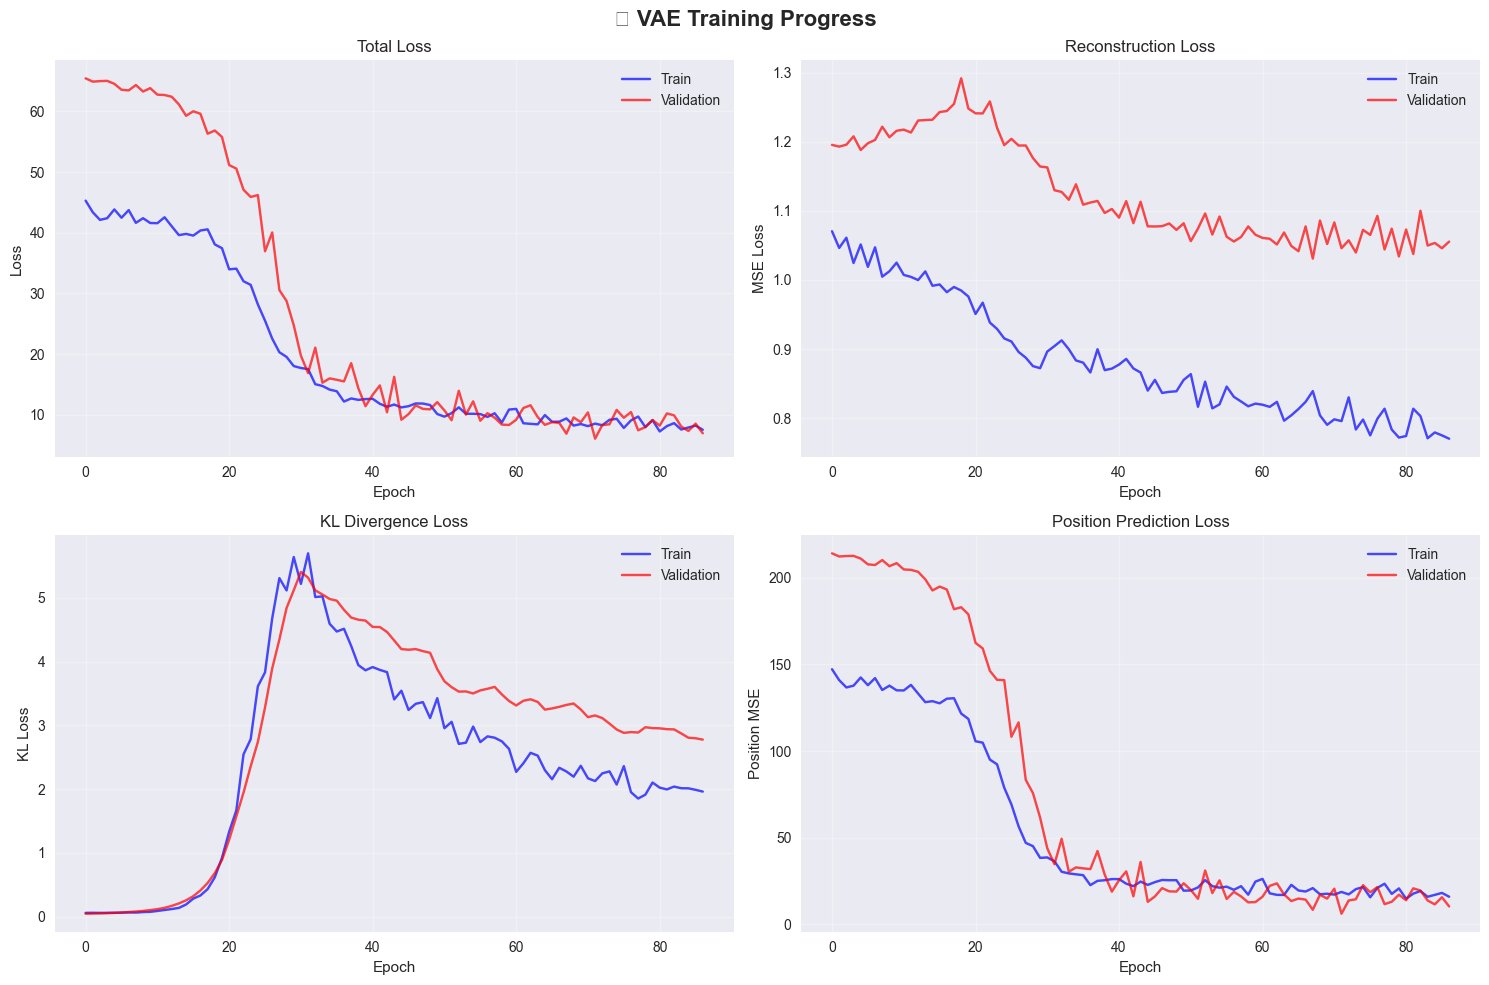


📈 Final Training Metrics:
  Total Loss: 6.9357
  Reconstruction: 1.0555
  KL Divergence: 2.7759
  Position Pred: 10.3479


In [7]:
if train_history and len(train_history['total_loss']) > 0:
    print("📊 Visualizing training progress...")
    
    # Create training plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('🧠 VAE Training Progress', fontsize=16, fontweight='bold')
    
    epochs = range(len(train_history['total_loss']))
    
    # Total loss
    axes[0,0].plot(epochs, train_history['total_loss'], 'b-', label='Train', alpha=0.7)
    axes[0,0].plot(epochs, train_history['val_total_loss'], 'r-', label='Validation', alpha=0.7)
    axes[0,0].set_title('Total Loss')
    axes[0,0].set_xlabel('Epoch')
    axes[0,0].set_ylabel('Loss')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # Reconstruction loss
    axes[0,1].plot(epochs, train_history['recon_loss'], 'b-', label='Train', alpha=0.7)
    axes[0,1].plot(epochs, train_history['val_recon_loss'], 'r-', label='Validation', alpha=0.7)
    axes[0,1].set_title('Reconstruction Loss')
    axes[0,1].set_xlabel('Epoch')
    axes[0,1].set_ylabel('MSE Loss')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # KL divergence loss
    axes[1,0].plot(epochs, train_history['kl_loss'], 'b-', label='Train', alpha=0.7)
    axes[1,0].plot(epochs, train_history['val_kl_loss'], 'r-', label='Validation', alpha=0.7)
    axes[1,0].set_title('KL Divergence Loss')
    axes[1,0].set_xlabel('Epoch')
    axes[1,0].set_ylabel('KL Loss')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # Position prediction loss
    axes[1,1].plot(epochs, train_history['pos_loss'], 'b-', label='Train', alpha=0.7)
    axes[1,1].plot(epochs, train_history['val_pos_loss'], 'r-', label='Validation', alpha=0.7)
    axes[1,1].set_title('Position Prediction Loss')
    axes[1,1].set_xlabel('Epoch')
    axes[1,1].set_ylabel('Position MSE')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print final metrics
    print(f"\n📈 Final Training Metrics:")
    print(f"  Total Loss: {train_history['val_total_loss'][-1]:.4f}")
    print(f"  Reconstruction: {train_history['val_recon_loss'][-1]:.4f}")
    print(f"  KL Divergence: {train_history['val_kl_loss'][-1]:.4f}")
    print(f"  Position Pred: {train_history['val_pos_loss'][-1]:.4f}")
else:
    print("❌ No training history to visualize.")

## 🔍 Model Evaluation and Latent Space Analysis

🔍 Evaluating trained VAE model...

📊 Model Performance:
  Reconstruction MSE: 0.7880
  Position Prediction MSE: 11.4360
  Position Prediction MAE: 2.6006
  Position Prediction R²: 0.6561

🌌 Latent Space Analysis:
  Latent dimensions: 4
  Mean latent activation: [1.7848374 2.1132927 1.3929081 1.5659889]
  Std latent activation: [1.2555593 1.4184649 0.9078944 0.9859441]


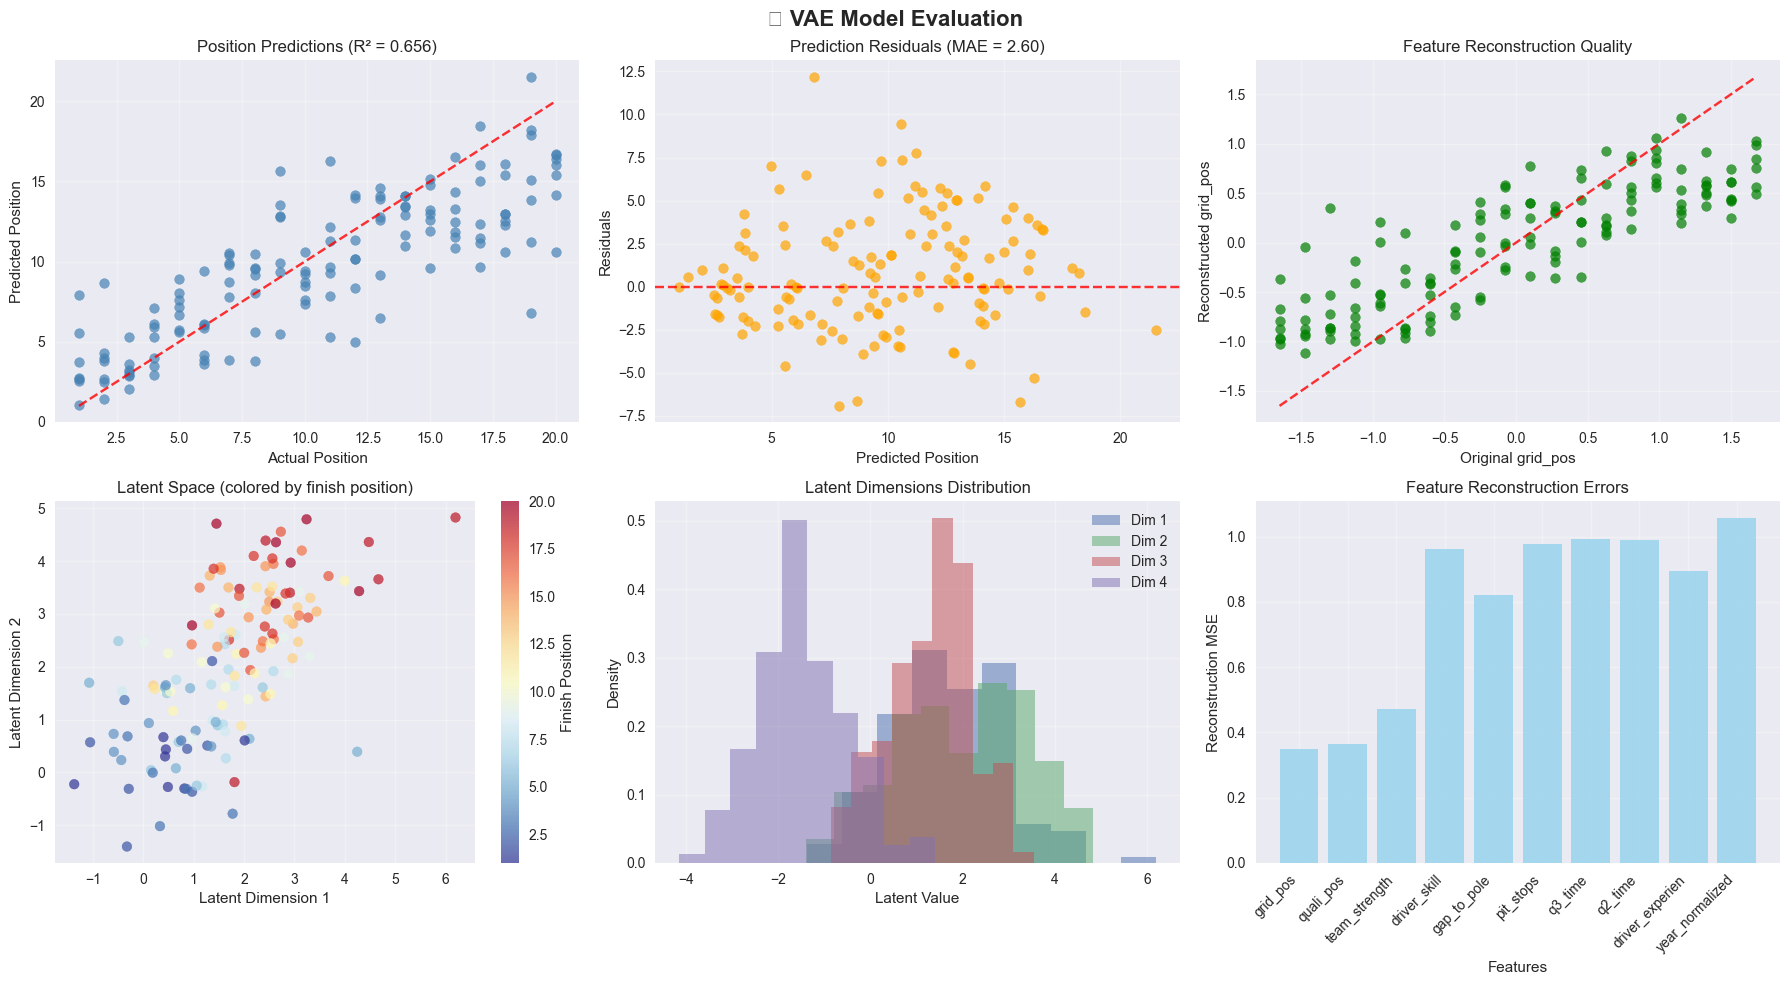


✅ Model evaluation completed!


In [8]:
if model is not None and not vae_df.empty:
    print("🔍 Evaluating trained VAE model...")
    
    model.eval()
    
    with torch.no_grad():
        # Get predictions for entire dataset
        X_full_tensor = torch.FloatTensor(X_vae)
        y_full_tensor = torch.FloatTensor(y_vae)
        
        recon_full, mu_full, logvar_full, z_full, pos_pred_full = model(X_full_tensor)
        
        # Convert to numpy for analysis
        X_recon = recon_full.numpy()
        latent_vectors = z_full.numpy()
        mu_vectors = mu_full.numpy()
        pos_predictions = pos_pred_full.squeeze().numpy()
        
        # Evaluation metrics
        recon_mse = mean_squared_error(X_vae.flatten(), X_recon.flatten())
        pos_mse = mean_squared_error(y_vae, pos_predictions)
        pos_mae = mean_absolute_error(y_vae, pos_predictions)
        pos_r2 = r2_score(y_vae, pos_predictions)
        
        print(f"\n📊 Model Performance:")
        print(f"  Reconstruction MSE: {recon_mse:.4f}")
        print(f"  Position Prediction MSE: {pos_mse:.4f}")
        print(f"  Position Prediction MAE: {pos_mae:.4f}")
        print(f"  Position Prediction R²: {pos_r2:.4f}")
        
        # Latent space statistics
        print(f"\n🌌 Latent Space Analysis:")
        print(f"  Latent dimensions: {latent_vectors.shape[1]}")
        print(f"  Mean latent activation: {np.mean(np.abs(latent_vectors), axis=0)}")
        print(f"  Std latent activation: {np.std(latent_vectors, axis=0)}")
    
    # Visualization of results
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('🔍 VAE Model Evaluation', fontsize=16, fontweight='bold')
    
    # Position predictions vs actual
    axes[0,0].scatter(y_vae, pos_predictions, alpha=0.7, color='steelblue')
    axes[0,0].plot([1, 20], [1, 20], 'r--', alpha=0.8)  # Perfect prediction line
    axes[0,0].set_xlabel('Actual Position')
    axes[0,0].set_ylabel('Predicted Position')
    axes[0,0].set_title(f'Position Predictions (R² = {pos_r2:.3f})')
    axes[0,0].grid(True, alpha=0.3)
    
    # Prediction residuals
    residuals = y_vae - pos_predictions
    axes[0,1].scatter(pos_predictions, residuals, alpha=0.7, color='orange')
    axes[0,1].axhline(y=0, color='r', linestyle='--', alpha=0.8)
    axes[0,1].set_xlabel('Predicted Position')
    axes[0,1].set_ylabel('Residuals')
    axes[0,1].set_title(f'Prediction Residuals (MAE = {pos_mae:.2f})')
    axes[0,1].grid(True, alpha=0.3)
    
    # Reconstruction quality for first feature
    feature_idx = 0  # grid_pos (most important feature)
    axes[0,2].scatter(X_vae[:, feature_idx], X_recon[:, feature_idx], alpha=0.7, color='green')
    x_min, x_max = X_vae[:, feature_idx].min(), X_vae[:, feature_idx].max()
    axes[0,2].plot([x_min, x_max], [x_min, x_max], 'r--', alpha=0.8)
    axes[0,2].set_xlabel(f'Original {feature_columns[feature_idx]}')
    axes[0,2].set_ylabel(f'Reconstructed {feature_columns[feature_idx]}')
    axes[0,2].set_title('Feature Reconstruction Quality')
    axes[0,2].grid(True, alpha=0.3)
    
    # Latent space visualization (first 2 dimensions)
    scatter = axes[1,0].scatter(latent_vectors[:, 0], latent_vectors[:, 1], 
                               c=y_vae, cmap='RdYlBu_r', alpha=0.7)
    axes[1,0].set_xlabel('Latent Dimension 1')
    axes[1,0].set_ylabel('Latent Dimension 2')
    axes[1,0].set_title('Latent Space (colored by finish position)')
    axes[1,0].grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=axes[1,0], label='Finish Position')
    
    # Latent dimensions distribution
    for i in range(min(4, latent_vectors.shape[1])):
        axes[1,1].hist(latent_vectors[:, i], bins=10, alpha=0.5, 
                      label=f'Dim {i+1}', density=True)
    axes[1,1].set_xlabel('Latent Value')
    axes[1,1].set_ylabel('Density')
    axes[1,1].set_title('Latent Dimensions Distribution')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    
    # Feature importance in reconstruction
    recon_errors = np.mean((X_vae - X_recon) ** 2, axis=0)
    feature_names_short = [name[:15] for name in feature_columns]
    axes[1,2].bar(range(len(feature_names_short)), recon_errors, 
                 color='skyblue', alpha=0.7)
    axes[1,2].set_xlabel('Features')
    axes[1,2].set_ylabel('Reconstruction MSE')
    axes[1,2].set_title('Feature Reconstruction Errors')
    axes[1,2].set_xticks(range(len(feature_names_short)))
    axes[1,2].set_xticklabels(feature_names_short, rotation=45, ha='right')
    axes[1,2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n✅ Model evaluation completed!")
else:
    print("❌ Cannot evaluate model without trained model and data.")

## 💾 Save Trained Model and Generate BN Integration Data

In [10]:
if model is not None and not vae_df.empty:
    print("💾 Saving trained VAE model and generating BN integration data...")
    
    # Create output directory
    os.makedirs('models', exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Save model state
    model_path = f"models/f1_vae_model_{timestamp}.pth"
    torch.save({
        'model_state_dict': model.state_dict(),
        'model_config': {
            'input_dim': input_dim,
            'latent_dim': latent_dim,
            'hidden_dims': hidden_dims
        },
        'training_history': train_history,
        'feature_columns': feature_columns,
        'best_val_loss': best_val_loss,
        'final_metrics': {
            'recon_mse': recon_mse,
            'pos_mse': pos_mse,
            'pos_mae': pos_mae,
            'pos_r2': pos_r2
        }
    }, model_path)
    
    print(f"✅ Model saved: {model_path}")
    
    # Generate latent vectors for BN integration
    model.eval()
    with torch.no_grad():
        # Get latent representations for entire dataset
        X_full_tensor = torch.FloatTensor(X_vae)
        mu_full, logvar_full = model.encode(X_full_tensor)
        z_full = model.reparameterize(mu_full, logvar_full)
        
        # Convert to DataFrame
        latent_df = pd.DataFrame(
            z_full.numpy(), 
            columns=[f'latent_dim_{i}' for i in range(latent_dim)]
        )
        
        # Add original indices and target for reference
        latent_df['original_index'] = range(len(latent_df))
        latent_df['finish_pos'] = y_vae
    
    # Save latent vectors for BN integration
    latent_path = f"data/preprocessed/vae_latent_vectors_{timestamp}.csv"
    latent_df.to_csv(latent_path, index=False)
    
    print(f"✅ Latent vectors saved: {latent_path}")
    print(f"   Shape: {latent_df.shape}")
    print(f"   Columns: {list(latent_df.columns)}")
    
    # Load BN input template and update with latent vectors
    bn_template_files = glob.glob('data/preprocessed/bn_input_template_*.csv')
    if bn_template_files:
        latest_bn_template = max(bn_template_files, key=os.path.getctime)
        bn_template = pd.read_csv(latest_bn_template)
        
        # Replace latent dimension placeholders with VAE output
        for i in range(latent_dim):
            bn_template[f'latent_dim_{i}'] = latent_df[f'latent_dim_{i}']
        
        # Save updated BN input
        bn_input_path = f"data/preprocessed/bn_input_with_vae_{timestamp}.csv"
        bn_template.to_csv(bn_input_path, index=False)
        
        print(f"✅ BN input with VAE latents saved: {bn_input_path}")
        print(f"   Shape: {bn_template.shape}")
        print(f"   Ready for Bayesian Network training!")
        
        # Show sample of BN input data
        print(f"\n🔍 Sample BN Input Data:")
        display(bn_template.head())
    
    # Create integration summary
    integration_summary = {
        'vae_model': {
            'path': model_path,
            'input_dim': input_dim,
            'latent_dim': latent_dim,
            'performance': {
                'recon_mse': float(recon_mse),
                'pos_mse': float(pos_mse),
                'pos_mae': float(pos_mae),
                'pos_r2': float(pos_r2)
            }
        },
        'integration_data': {
            'latent_vectors_path': latent_path,
            'bn_input_path': bn_input_path,
            'latent_dimensions': latent_dim,
            'sample_count': len(latent_df)
        },
        'next_steps': [
            "Load bn_input_with_vae_*.csv for Bayesian Network training",
            "Use latent_dim_0 to latent_dim_3 as continuous evidence nodes",
            "Target: finish_pos_binned_encoded for discrete prediction",
            "Implement Bayesian Network with VAE latent + categorical features"
        ]
    }
    
    summary_path = f"models/vae_integration_summary_{timestamp}.json"
    with open(summary_path, 'w') as f:
        json.dump(integration_summary, f, indent=2)
    
    print(f"\n📋 Integration summary saved: {summary_path}")
    
    print(f"\n🎉 VAE IMPLEMENTATION COMPLETE!")
    print(f"✅ Model trained and saved")
    print(f"✅ Latent vectors generated")
    print(f"✅ BN integration data ready")
    print(f"🚀 Ready for Bayesian Network implementation!")

else:
    print("❌ Cannot save model without trained model and data.")

💾 Saving trained VAE model and generating BN integration data...
✅ Model saved: models/f1_vae_model_20251005_180957.pth
✅ Latent vectors saved: data/preprocessed/vae_latent_vectors_20251005_180957.csv
   Shape: (140, 6)
   Columns: ['latent_dim_0', 'latent_dim_1', 'latent_dim_2', 'latent_dim_3', 'original_index', 'finish_pos']

📋 Integration summary saved: models/vae_integration_summary_20251005_180957.json

🎉 VAE IMPLEMENTATION COMPLETE!
✅ Model trained and saved
✅ Latent vectors generated
✅ BN integration data ready
🚀 Ready for Bayesian Network implementation!
